# Fisher Matrix for Global 21-cm Signal

In [369]:
import numpy as np
import ares
from scipy import interpolate

In [370]:
def data_matrix(nu, params):
    ### 1- A matrix for saving the data: M.shape= (1+3*npar, lennu)
    #         first row: nu, len(nu) = lennu
    #         next 2: first parameter's 2 neighbors
    #         next 2: second parameter's 2 neighbors ...
####################################################################
    M = nu   
    sim = ares.simulations.Global21cm(**params, verbose=False)     # Initialize a simulation object
    sim.run() 
    x = sim.history['nu']
    y = sim.history['dTb']
    f = interpolate.interp1d(x, y)
#         M = np.vstack((M,f(nu)))
    return f(nu)

def derivative_matrix(mat, step):
    ### 2- A function to take derivative matrix consisted of:
    #         first row: nu
    #         2nd row: derivative wr/ first parameter 
    #         3rd row: derivative wr/ second parameter  ...
#############################################################
    row = mat.shape[0]
    deriv = mat[0]
    for i in range(row):
        if i>1 & i%2==0:
            stp_i = np.int((i-2)/2)
            nrow = (mat[i+1,:]-mat[i,:])/2/step[stp_i]
            deriv = np.vstack((deriv,nrow))        
    return deriv

def Fisher_elements(der_mat, sigma):
    ### 3- A function to calculate the Fisher elements using 
    ### the 21-cm formula. 
##############################################################
    p_num = der_mat.shape[0]-1
    Fish = np.zeros([p_num,p_num])
    for i in range(p_num):
        for j in range(p_num):
            cross = np.multiply(der_mat[i+1],der_mat[j+1]) / sigma**2
            Fish[i,j] = np.sum(cross)
    return Fish

In [371]:
names = np.array( ['fX', 'fstar', 'Nion',  'Nlw', 'Tmin'])
fids = np.array([1.0, 0.1, 4000.0, 9690.0, 1e4])
steps = np.array([0.1, 0.001, 100, 100, 1e3])
par_fid = {}
for i,name in enumerate(names):
    par_fid.update({name: fids[i]})
print(par_fid)

{'fX': 1.0, 'fstar': 0.1, 'Nion': 4000.0, 'Nlw': 9690.0, 'Tmin': 10000.0}


In [372]:
nu_test = np.linspace(5, 230, 1000)
MM = nu_test
MM = np.vstack((MM,data_matrix(nu_test, par_fid)))

for i,name in enumerate(names):
    parss = par_fid
#     print('1',parss)
    
    parss.update({name: fids[i]+steps[i]})
#     print('2',parss)
    MM = np.vstack((MM,data_matrix(nu_test, parss)))
    
    parss.update({name: fids[i]-steps[i]})
#     print('3',parss, "\n")
    MM = np.vstack((MM,data_matrix(nu_test, parss)))

    parss.update({name: fids[i]})

# np.vstack((nu_test,nu_test))
# np.concatenate((nu_test,nu_test), axis=0)


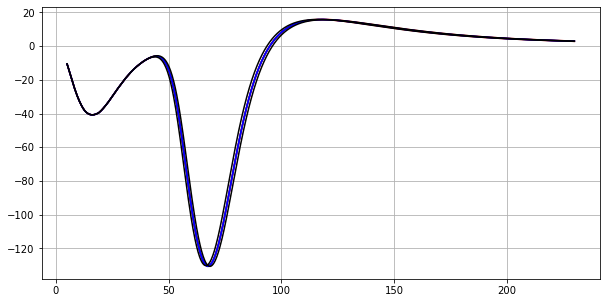

In [373]:
plt.subplots(figsize=(10,5))
MM.shape
plt.plot(MM[0],MM[1])
plt.plot(MM[0],MM[6],"r")
plt.plot(MM[0],MM[7],"r")
plt.plot(MM[0],MM[8],"b")
plt.plot(MM[0],MM[9],"b")
plt.plot(MM[0],MM[10],"k")
plt.plot(MM[0],MM[11],"k")
plt.grid()

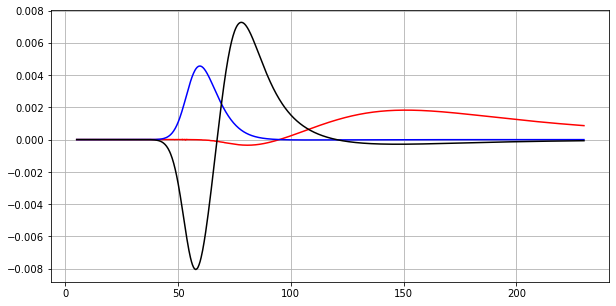

In [374]:
derMM = derivative_matrix(MM, steps)

plt.subplots(figsize=(10,5))

MM.shape
# plt.plot(derMM[0],derMM[1], "r")
# plt.plot(derMM[0],derMM[2], "b")
plt.plot(derMM[0],derMM[3], "r")
plt.plot(derMM[0],derMM[4], "b")
plt.plot(derMM[0],derMM[5], "k") 
plt.grid()

In [375]:
sig = 10 #mK
FisherMatrix = Fisher_elements(derMM, sig)

In [376]:
FisherMatrix

array([[ 2.81088959e+03,  2.34343193e+04,  4.29016460e-03,
        -4.87714709e-02, -2.94879312e-01],
       [ 2.34343193e+04,  3.09067424e+05,  4.66918880e-01,
         5.89500735e-01, -4.19330271e+00],
       [ 4.29016460e-03,  4.66918880e-01,  1.13591569e-05,
        -3.18170132e-07, -2.65819156e-06],
       [-4.87714709e-02,  5.89500735e-01, -3.18170132e-07,
         1.12373193e-05, -1.18766108e-05],
       [-2.94879312e-01, -4.19330271e+00, -2.65819156e-06,
        -1.18766108e-05,  6.22242419e-05]])

generating new axis
['fX' 'fstar' 'Nion' 'Nlw' 'Tmin']


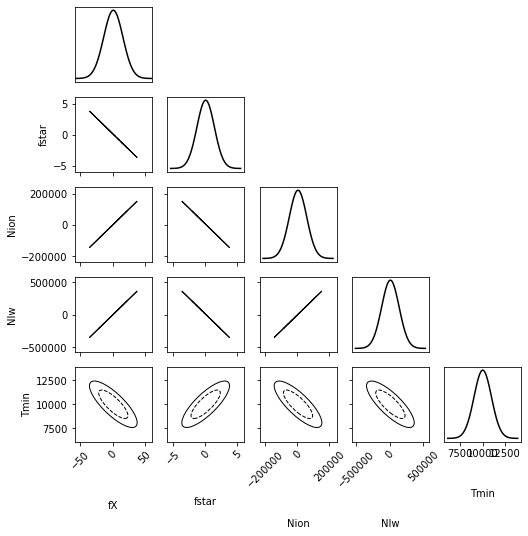

In [377]:
from fishchips.cosmo import Observables
import fishchips.util

cov = np.linalg.inv(FisherMatrix)
cov
obs = Observables(parameters=names,
                  fiducial=fids,
                  left=fids-steps,
                  right=fids+steps)

fishchips.util.plot_triangle(obs, cov, labels=names)
plt.savefig('triangle.pdf')

In [378]:
for i in range(5):
    print(names[i], "\t", fids[i], "\t", np.round(np.sqrt(cov[i,i]),2))

fX 	 1.0 	 14.85
fstar 	 0.1 	 1.5
Nion 	 4000.0 	 59969.78
Nlw 	 9690.0 	 144080.2
Tmin 	 10000.0 	 975.22
